# <font color=salmon>PART 1 - RAPPEL DU CONTEXTE PROJET</font>

## **<font color=green>Le projet</font>**

Notre projet consiste à **concevoir, entraîner et déployer un modèle de segmentation d'images**, qui s'intégrera facilement dans la chaîne complète du système embarqué d'une voiture autonome :
1. l'acquisition des images en temps réel ;
2. le traitement des images ;
3. la <font color=blue>**segmentation des images**</font> ; 
4. et enfin, le système de décision.

## **<font color=green>Le jeu de données</font>**

Nous allons travailler avec le jeu de données [Cityscapes](https://www.cityscapes-dataset.com/dataset-overview/):
- 2380 images et masques annotés dans le Train Set;
- 595 images et masques annotés dans le Validation Set;
- 500 images et masques annotés dans le Test Set.

# <font color=salmon>PART 2 - LIBRAIRIES, PARAMETRES, HELPERS</font>

## **<font color=green>Chargement des librairies</font>**

In [ ]:
import pandas as pd
import numpy as np
import os, glob
import random
from time import time
import tqdm
import six
from collections import namedtuple

import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

from imgaug import augmenters as iaa

print("Tensorflow version " + tf.__version__)
print("OpenCV " + cv2.__version__)

Tensorflow version 2.7.0
OpenCV 4.1.2


## **<font color=green>Chargement des données</font>**

In [ ]:
# Set all paths to folders: project, model, images, masks
project_path = '/content/drive/MyDrive/OC_IA/P08'
model_path = '/content/drive/MyDrive/OC_IA/P08/model'
checkpoint_path = '/content/drive/MyDrive/OC_IA/P08/checkpoints'
train_input_dir = '/content/drive/MyDrive/OC_IA/P08/dataset/train/images'
train_mask_dir = '/content/drive/MyDrive/OC_IA/P08/dataset/train/masks30'
train_target_dir = '/content/drive/MyDrive/OC_IA/P08/dataset/train/masks'
val_input_dir = '/content/drive/MyDrive/OC_IA/P08/dataset/val/images'
val_mask_dir = '/content/drive/MyDrive/OC_IA/P08/dataset/val/masks30'
val_target_dir = '/content/drive/MyDrive/OC_IA/P08/dataset/val/masks'
test_input_dir = '/content/drive/MyDrive/OC_IA/P08/dataset/test/images'
test_mask_dir = '/content/drive/MyDrive/OC_IA/P08/dataset/test/masks30'
test_target_dir = '/content/drive/MyDrive/OC_IA/P08/dataset/test/masks'

In [ ]:
train_input_path = sorted(glob.glob(train_input_dir + '/*.png'))
train_mask_path = sorted(glob.glob(train_mask_dir +'/*.png'))
train_target_path = sorted(glob.glob(train_target_dir +'/*.png'))
print('TRAIN -- Number of images: ', len(train_input_path), 
      ' - Number of original masks: ', len(train_mask_path),
      ' - Number of target (8 categories): ', len(train_target_path))
print(train_input_path[0] + '\n')

val_input_path = sorted(glob.glob(val_input_dir + '/*.png'))
val_mask_path = sorted(glob.glob(val_mask_dir +'/*.png'))
val_target_path = sorted(glob.glob(val_target_dir +'/*.png'))
print('TRAIN -- Number of images: ', len(val_input_path), 
      ' - Number of original masks: ', len(val_mask_path),
      ' - Number of target (8 categories): ', len(val_target_path))
print(val_input_path[0] + '\n')

test_input_path = sorted(glob.glob(test_input_dir + '/*.png'))
test_mask_path = sorted(glob.glob(test_mask_dir +'/*.png'))
test_target_path = sorted(glob.glob(test_target_dir +'/*.png'))
print('TRAIN -- Number of images: ', len(test_input_path), 
      ' - Number of original masks: ', len(test_mask_path),
      ' - Number of target (8 categories): ', len(test_target_path))
print(test_input_path[0])

TRAIN -- Number of images:  2380  - Number of original masks:  2380  - Number of target (8 categories):  2380
/content/drive/MyDrive/OC_IA/P08/dataset/train/images/aachen_000000_000019.png

TRAIN -- Number of images:  595  - Number of original masks:  595  - Number of target (8 categories):  595
/content/drive/MyDrive/OC_IA/P08/dataset/val/images/stuttgart_000104_000019.png

TRAIN -- Number of images:  500  - Number of original masks:  500  - Number of target (8 categories):  500
/content/drive/MyDrive/OC_IA/P08/dataset/test/images/frankfurt_000000_000294.png


## **<font color=green>Visualisation d'une image et de son masque</font>**

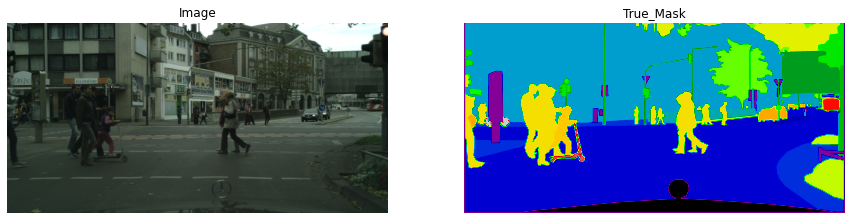

In [ ]:
# Load image and mask
image = img_to_array(load_img(f'{train_input_path[14]}'))/255.
mask = img_to_array(load_img(f'{train_mask_path[14]}', color_mode = "grayscale"))
mask = np.squeeze(mask)

# Plot
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Image')
ax.imshow(image)
ax.axis('off')

ax1 = fig.add_subplot(1, 2, 2)
ax1.set_title('True_Mask')
ax1.imshow(mask, cmap='nipy_spectral')
ax1.axis('off')
plt.show()

## **<font color=green>Fonctions d'aide (helpers)</font>**

### **<font color=blue>Dataframe de sauvegarde des résultats</font>**

In [ ]:
# Prepare dataframe to save results
df_result = pd.DataFrame(
    columns= ['model',
              'epoch',
              'training_time',
              'eval_time',
              'freq_weighted_IoU',
              'mean_IoU',
              'void_IoU',
              'flat_IoU',
              'construction_IoU',
              'object_IoU',
              'nature_IoU',
              'sky_IoU',
              'human_IoU',
              'vehicule_IoU'])

# Save to CSV
df_result.to_csv(project_path +'/p8_bench_models.csv', index=False)

In [ ]:
# Append model's result to dataframe
def model_result_to_dataframe(model_name, epochs, training_time, eval_time, 
                              df_result, model_result, do_augment=False):

    if do_augment==True:
        model_name = (f'augmented_{model_name}')

    df_result =df_result.append(
        {'model':model_name,
         'epoch': epochs,
         'training_time':training_time,
         'eval_time':eval_time,
         'freq_weighted_IoU':model_result["frequency_weighted_IU"],
         'mean_IoU':model_result["mean_IU"],
         'void_IoU':model_result["class_wise_IU"][0],
         'flat_IoU':model_result["class_wise_IU"][1],
         'construction_IoU':model_result["class_wise_IU"][2],
         'object_IoU':model_result["class_wise_IU"][3],
         'nature_IoU':model_result["class_wise_IU"][4],
         'sky_IoU':model_result["class_wise_IU"][5],
         'human_IoU':model_result["class_wise_IU"][6],
         'vehicule_IoU':model_result["class_wise_IU"][7]},
         ignore_index=True)
    
    return df_result

### **<font color=blue>Visualisation des prédictions</font>**

In [ ]:
# Function to resize image
def resize_dataset(pred, img_width, img_height):
    img = pred
    # Use interpolation inter_nearest to use integer with cv2
    resized_img = cv2.resize(img, dsize=(img_width, img_height),
                             interpolation=cv2.INTER_NEAREST)
    return resized_img

# Function to plot original images and masks VS. predicted masks
def plot_image_mask_prediction(test_input_path, test_target_path, 
                               img_height, img_width, random=True, n=5):
    
    if random:
        # Generate random images/masks of n-number
        ids = np.random.choice(np.arange(len(test_input_path)), size=n)
        print(ids)
    
    else:
        ids = [498, 175]
    
    # Plot
    for i in ids:
        image = img_to_array(load_img(f'{test_input_path[i]}'))/255.
        mask = img_to_array(load_img(f'{test_target_path[i]}',
                                     color_mode = "grayscale"))
        mask = np.squeeze(mask)
        pred = model.predict_segmentation(inp=test_input_path[i])
        pred= resize_dataset(pred, img_width, img_height)
        
        fig = plt.figure(figsize=(20, 20))
        ax = fig.add_subplot(1, 3, 1)
        ax.set_title('Image')
        ax.imshow(image)
        
        ax1 = fig.add_subplot(1, 3, 2)
        ax1.set_title('True mask')
        ax1.imshow(mask, cmap='nipy_spectral_r' )
        
        ax2 = fig.add_subplot(1, 3, 3)
        ax2.set_title('predicted_Mask')
        ax2.imshow(pred, cmap='nipy_spectral_r')

## **<font color=green>Paramètres de modèle</font>**

In [ ]:
# Set parameters & hyperparameters
img_height, img_width = 256, 512
img_size = (img_height, img_width)
batch_size = 16
n_classes = 8
samples = len(train_input_path)
optimizer = 'adam'
loss='categorical_crossentropy'
score_IoU = tf.keras.metrics.MeanIoU(num_classes=8,
                                     name='mean_IoU')
epochs = 10
epochs_optim = 3

# <font color=salmon>PART 3 - BENCHMARK DES MODELES</font>

## **<font color=green>UNET from scratch</font>**

Cette partie de l'expérimentation nous sert à construire et tester notre **générateur de données**. 

**Sources utilisées** : 
- [**Keras - Oxford Pets : Image segmentation**](https://keras.io/examples/vision/oxford_pets_image_segmentation/)
- [**Stanford - Afshine & Shervine Amidi - Data Generators with Keras**](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)
- [**Bastien Maurice - Générateur de données**](https://deeplylearning.fr/cours-pratiques-deep-learning/realiser-son-propre-generateur-de-donnees/)

### **<font color=blue>Mapper les categories principales (fonction)</font>**

In [ ]:
from collections import namedtuple

# Adaptation from the official Cityscapes scripts
# https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

#--------------------------------------------------------------------------------
# Definitions : 
#--------------------------------------------------------------------------------
# Create tuple subclasses with named fields
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name the 30 classes

    'id'          , # An integer ID that is associated with this label.

    'categoryId'       , # IDs of labels which match to pixel values
                    # corresponding to the 8 main categories.

    'category'    , # The name of the category that this label belongs to
    ] )

#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

labels = [
    #name                             id    catId   category
    Label(  'unlabeled'            ,  0 ,      0 , 'void'),
    Label(  'ego vehicle'          ,  1 ,      0 , 'void'),
    Label(  'rectification border' ,  2 ,      0 , 'void'),
    Label(  'out of roi'           ,  3 ,      0 , 'void'),
    Label(  'static'               ,  4 ,      0 , 'void'),
    Label(  'dynamic'              ,  5 ,      0 , 'void'),
    Label(  'ground'               ,  6 ,      0 , 'void'),
    Label(  'road'                 ,  7 ,      1 , 'flat'),
    Label(  'sidewalk'             ,  8 ,      1 , 'flat'),
    Label(  'parking'              ,  9 ,      1 , 'flat'),
    Label(  'rail track'           , 10 ,      1 , 'flat'),
    Label(  'building'             , 11 ,      2 , 'construction'),
    Label(  'wall'                 , 12 ,      2 , 'construction'),
    Label(  'fence'                , 13 ,      2 , 'construction'),
    Label(  'guard rail'           , 14 ,      2 , 'construction'),
    Label(  'bridge'               , 15 ,      2 , 'construction'),
    Label(  'tunnel'               , 16 ,      2 , 'construction'),
    Label(  'pole'                 , 17 ,      3 , 'object'),
    Label(  'polegroup'            , 18 ,      3 , 'object'),
    Label(  'traffic light'        , 19 ,      3 , 'object'),
    Label(  'traffic sign'         , 20 ,      3 , 'object'),
    Label(  'vegetation'           , 21 ,      4 , 'nature'),
    Label(  'terrain'              , 22 ,      4 , 'nature'),
    Label(  'sky'                  , 23 ,      5 , 'sky'),
    Label(  'person'               , 24 ,      6 , 'human'),
    Label(  'rider'                , 25 ,      6 , 'human'),
    Label(  'car'                  , 26 ,      7 , 'vehicle'),
    Label(  'truck'                , 27 ,      7 , 'vehicle'),
    Label(  'bus'                  , 28 ,      7 , 'vehicle'),
    Label(  'caravan'              , 29 ,      7 , 'vehicle'),
    Label(  'trailer'              , 30 ,      7 , 'vehicle'),
    Label(  'train'                , 31 ,      7 , 'vehicle'),
    Label(  'motorcycle'           , 32 ,      7 , 'vehicle'),
    Label(  'bicycle'              , 33 ,      7 , 'vehicle'),
    Label(  'license plate'        , -1 ,      7 , 'vehicle')]

# Function to map labels and categories
def map_id2category(labels):
    """ This function maps the ~30 labels' IDs
        to the 8 main categories' IDs
    """
    cat_label = {label.id: label.categoryId for label in labels}
    
    # Get the mapping
    map_category = np.vectorize(cat_label.get)
    return map_category

### **<font color=blue>Générer les données (Générateur customisé)</font>**

In [ ]:
class DataGenerator(Sequence):
    """Generate data for Keras
    """

    # ==== Initialize the class ==== #
    def __init__(self, input_path, target_path, img_size, batch_size, 
                 labels, n_classes, shuffle):
        self.input_path = input_path
        self.target_path = target_path
        self.targetSize = img_size
        self.batch_size = batch_size
        self.labels = labels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()


    # ==== Set the number of batches per epoch ==== #
    def __len__(self):
        return int(np.floor(len(self.input_path) / float(self.batch_size)))
    
    
    # ==== Call a method at the end of each epoch ==== #
    def on_epoch_end(self):
        # [0,1,2,3,4... nb_image]
        self.indexes = np.arange(len(self.input_path))
        
        # [2,4,1,3,0... nb_image]
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    
    # ==== Get batches of images & masks ==== #
    def __getitem__(self, index):
       # Genere batch_size nombre d'ID de row de DATA (batch_size=2, [0,1])
       currentBatchIdsRow = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
    
       batch_x, batch_y = [], []
    
       # Iterate over indexes
       for i, rowId in enumerate(currentBatchIdsRow):
           # Load image, set target size, convert to array, normalize
           image = img_to_array(
               load_img(f'{self.input_path[i]}', 
                        target_size=img_size))/255.
           batch_x.append(image)

           # Load original mask, set target size and convert to array
           mask30 = img_to_array(
               load_img(f'{self.target_path[i]}', color_mode = "grayscale", 
                        target_size=img_size))
           
           # Map the 30 classes to 8 main categories
           map_category = map_id2category(labels)
           mask = map_category(mask30)
           mask = to_categorical(mask, self.n_classes)                   
           batch_y.append(mask)
     
       return np.array(batch_x), np.array(batch_y)

In [ ]:
# Generate data
trainGen = DataGenerator(train_input_path, train_mask_path, img_size, 
                         batch_size, labels, n_classes, shuffle=False)
valGen = DataGenerator(val_input_path, val_mask_path, img_size, 
                       batch_size, labels, n_classes, shuffle=False)

# Check data shape
X_train, y_train = trainGen.__getitem__(0)
print('Train shapes (X and y): ', X_train.shape, y_train.shape)
X_val, y_val = valGen.__getitem__(0)
print('Val shapes (X and y): ', X_val.shape, y_val.shape)

Train shapes (X and y):  (16, 256, 512, 3) (16, 256, 512, 8)
Val shapes (X and y):  (16, 256, 512, 3) (16, 256, 512, 8)


### **<font color=blue>Créer le modèle</font>**

In [ ]:
# Get Unet-Xception model
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

### **<font color=blue>Appeler le modèle</font>**

In [ ]:
# Clear previous session
# Free up RAM in case the model definition cells were run multiple times
K.clear_session()

# Name next model to benchmark
model_name= 'unet_xception_scratch'

# Build model
#with tpu_strategy.scope():
model = get_model(img_size, n_classes)   
model.compile(optimizer=optimizer, 
              loss=loss,
              metrics=[score_IoU, 'accuracy'])

In [ ]:
# Check model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

### **<font color=blue>Entraîner le modèle</font>**

In [ ]:
print(f'Training for {model_name}')

# Set checkpoint
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}.h5', 
                             save_best_only=True)]

# Train the model
start = time()
history = model.fit(trainGen, 
                    epochs=epochs,
                    validation_data = valGen,
                    workers=8,
                    callbacks=callbacks)

training_time = time() - start
print(f'Training time : {training_time}')

# Save the model
model.save(model_path+f'/{model_name}.h5')

Training for unet_xception_scratch
Epoch 1/10
148/148 [==============================] - ETA: 0s - loss: 0.4521 - mean_IoU: 0.4388 - accuracy: 0.8845

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


148/148 [==============================] - 335s 2s/step - loss: 0.4521 - mean_IoU: 0.4388 - accuracy: 0.8845 - val_loss: 2.1125 - val_mean_IoU: 0.4375 - val_accuracy: 0.4117
Epoch 2/10
148/148 [==============================] - 299s 2s/step - loss: 0.0926 - mean_IoU: 0.4515 - accuracy: 0.9645 - val_loss: 4.6846 - val_mean_IoU: 0.4375 - val_accuracy: 0.4187
Epoch 3/10
148/148 [==============================] - 314s 2s/step - loss: 0.0501 - mean_IoU: 0.4967 - accuracy: 0.9805 - val_loss: 6.7095 - val_mean_IoU: 0.4382 - val_accuracy: 0.4309
Epoch 4/10
148/148 [==============================] - 304s 2s/step - loss: 0.0311 - mean_IoU: 0.5475 - accuracy: 0.9884 - val_loss: 4.0431 - val_mean_IoU: 0.4528 - val_accuracy: 0.5374
Epoch 5/10
148/148 [==============================] - 310s 2s/step - loss: 0.0242 - mean_IoU: 0.5831 - accuracy: 0.9917 - val_loss: 3.1167 - val_mean_IoU: 0.4944 - val_accuracy: 0.6370
Epoch 6/10
148/148 [==============================] - 300s 2s/step - loss: 0.1430 - me

### **<font color=blue>Graphique des courbes d'apprentissage</font>**

In [ ]:
# Function to plot learning curves
def plot_graphs(history):
    plt.figure(figsize=(30,6))
    
    plt.subplot(131)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'])
    
    plt.subplot(132)
    plt.plot(history.history['mean_IoU'])
    plt.plot(history.history['val_mean_IoU'])
    plt.xlabel('Epochs')
    plt.ylabel('mean_IoU')
    plt.legend(['mean_IoU', 'val_mean_IoU'])
    
    plt.subplot(133)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend(['accuracy', 'val_accuracy'])
    plt.show()

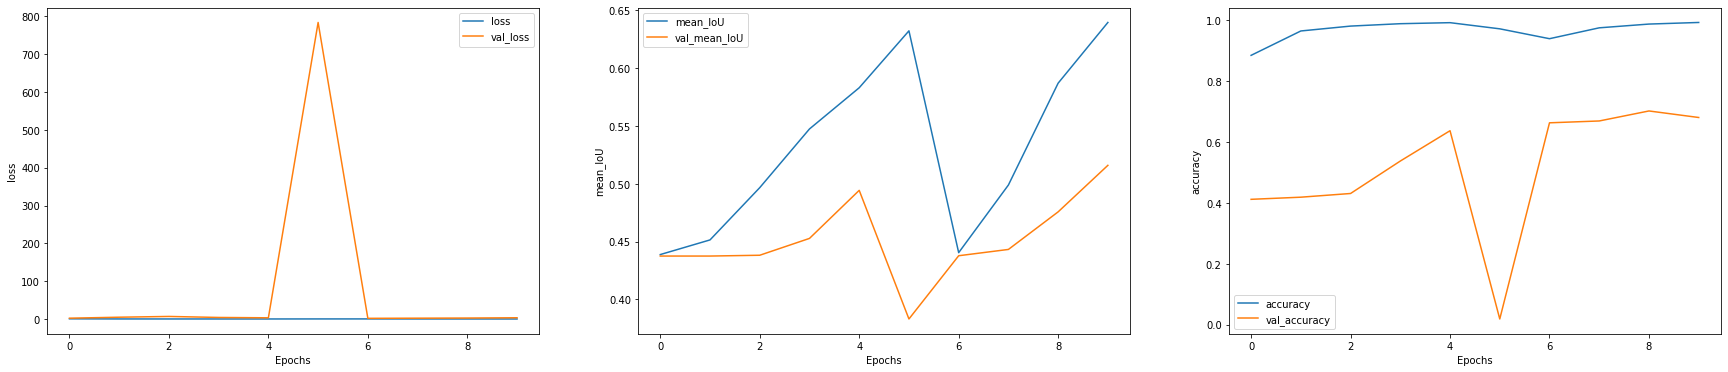

In [ ]:
# Plot learning curves
plot_graphs(history)

### **<font color=blue>Evaluer le modèle</font>**

In [ ]:
# Reload the model
model = tf.keras.models.load_model(
    checkpoint_path+f'/{model_name}.h5', custom_objects={'mean_IoU': score_IoU})

In [ ]:
# Generate test data
testGen = DataGenerator(test_input_path, test_mask_path, img_size, 
                       batch_size, labels, n_classes, shuffle=False)

In [ ]:
# Evaluate the model
start_eval = time()
val_preds = model.predict(testGen)
eval_time = time() - start_eval
print(f'Evaluation time : {eval_time}')

Evaluation time : 91.17858982086182


### **<font color=blue>Visualiser les prédictions</font>**

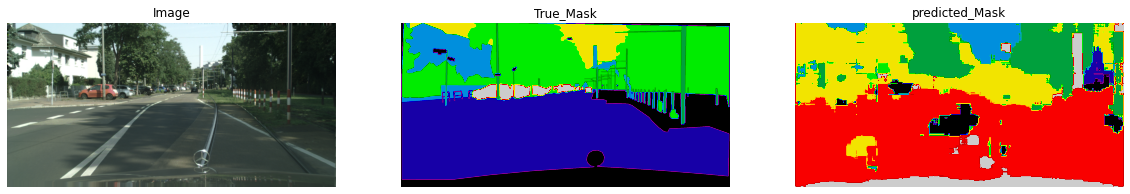

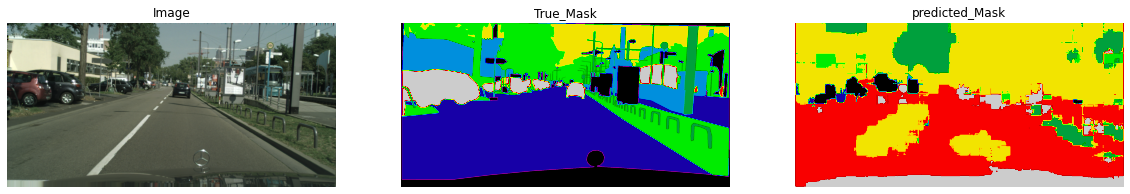

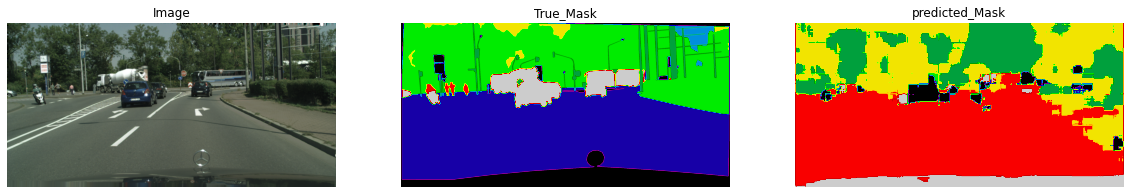

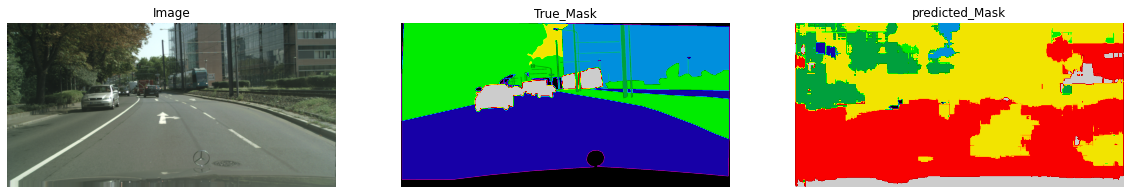

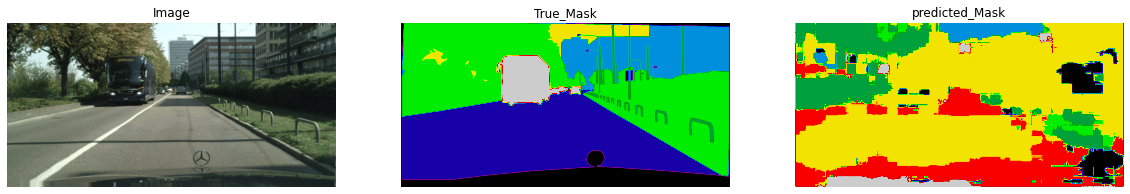

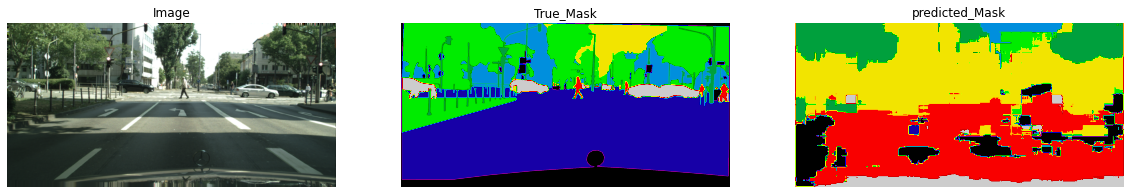

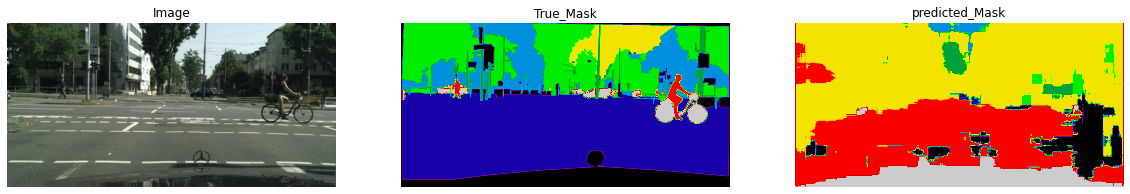

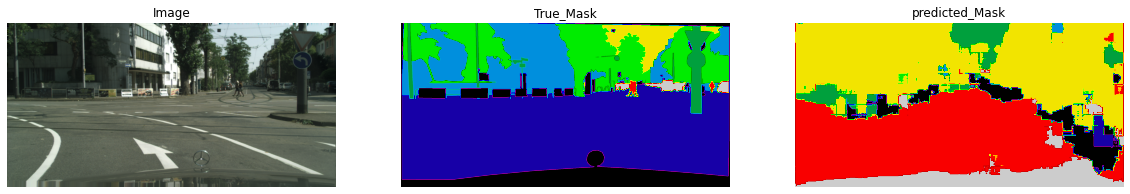

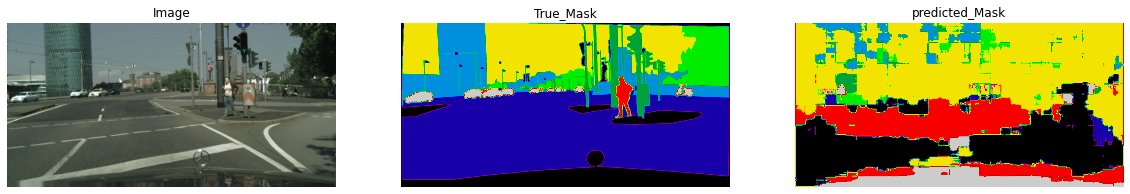

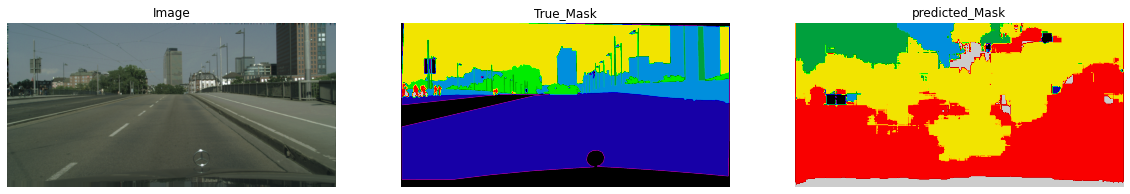

In [ ]:
# Display results for validation image #10

for i in range(10,20):
    image = img_to_array(load_img(f'{test_input_path[i]}'))/255.
    mask = img_to_array(load_img(f'{test_target_path[i]}', color_mode = "grayscale"))
    mask = np.squeeze(mask)
    pred_mask = np.argmax(val_preds[i], axis=-1)
    pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask = np.squeeze(pred_mask)


    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Image')
    ax.imshow(image)
    ax.axis('off')

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_title('True_Mask')
    ax2.imshow(mask, cmap='nipy_spectral')
    ax2.axis('off')

    ax1 = fig.add_subplot(1, 3, 3)
    ax1.set_title('predicted_Mask')
    ax1.imshow(pred_mask, cmap='nipy_spectral_r')
    ax1.axis('off')

<font color=red>**Ce modèle ne semble absolument pas adapté à notre problématique mais nous avons pu tester l'efficacité de notre générateur de données!**</font>

## **<font color=green>FCN8 - Mobilenet</font>**

### **<font color=blue>Package : Image Segmentation Keras - Divam Gupta</font>**

Pour la suite de notre expérimentation, nous allons utiliser un dépôt GitHub qui nous permettra **d'accélerer la sélection du modèle adapté à notre use-case**.

**Auteur du dépôt GitHub** : [**Divam Gupta**](https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html)

In [ ]:
from IPython.display import clear_output
!pip install --upgrade git+https://github.com/zatafa/image-segmentation-keras.git
clear_output()

from keras_segmentation.models.fcn import fcn_8_mobilenet
from keras_segmentation.models.unet import vgg_unet
from keras_segmentation.models.segnet import mobilenet_segnet

### **<font color=blue>Appeler le modèle</font>**

In [ ]:
# Clear previous session
K.clear_session()

# Name next model to benchmark
model_name= 'fcn_8_mobilenet'

# Call the model
model = fcn_8_mobilenet(n_classes=n_classes,
                        input_height=img_height,
                        input_width=img_width)

17235968/17225924 [==============================] - 1s 0us/step


In [ ]:
# Check model summary
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 258, 514, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 128, 256, 32  864         ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### **<font color=blue>Entraîner le modèle</font>**

Training for fcn_8_mobilenet
Verifying training dataset


100%|██████████| 2380/2380 [24:55<00:00,  1.59it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 595/595 [04:19<00:00,  2.29it/s]


Dataset verified! 
Epoch 1/10
512/512 [==============================] - ETA: 0s - loss: 0.4812 - score_IoU: 0.4376 - accuracy: 0.8441

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


512/512 [==============================] - 1034s 2s/step - loss: 0.4812 - score_IoU: 0.4376 - accuracy: 0.8441 - val_loss: 0.3399 - val_score_IoU: 0.4377 - val_accuracy: 0.8944
Epoch 2/10
512/512 [==============================] - 977s 2s/step - loss: 0.2543 - score_IoU: 0.4423 - accuracy: 0.9144 - val_loss: 0.3552 - val_score_IoU: 0.4420 - val_accuracy: 0.8787
Epoch 3/10
512/512 [==============================] - 956s 2s/step - loss: 0.2067 - score_IoU: 0.4598 - accuracy: 0.9287 - val_loss: 0.3618 - val_score_IoU: 0.4452 - val_accuracy: 0.9046
Epoch 4/10
512/512 [==============================] - 984s 2s/step - loss: 0.1759 - score_IoU: 0.4908 - accuracy: 0.9381 - val_loss: 0.3641 - val_score_IoU: 0.4920 - val_accuracy: 0.9092
Epoch 5/10
512/512 [==============================] - 995s 2s/step - loss: 0.1600 - score_IoU: 0.5273 - accuracy: 0.9427 - val_loss: 0.3810 - val_score_IoU: 0.5001 - val_accuracy: 0.9047
Epoch 6/10
512/512 [==============================] - 966s 2s/step - loss: 

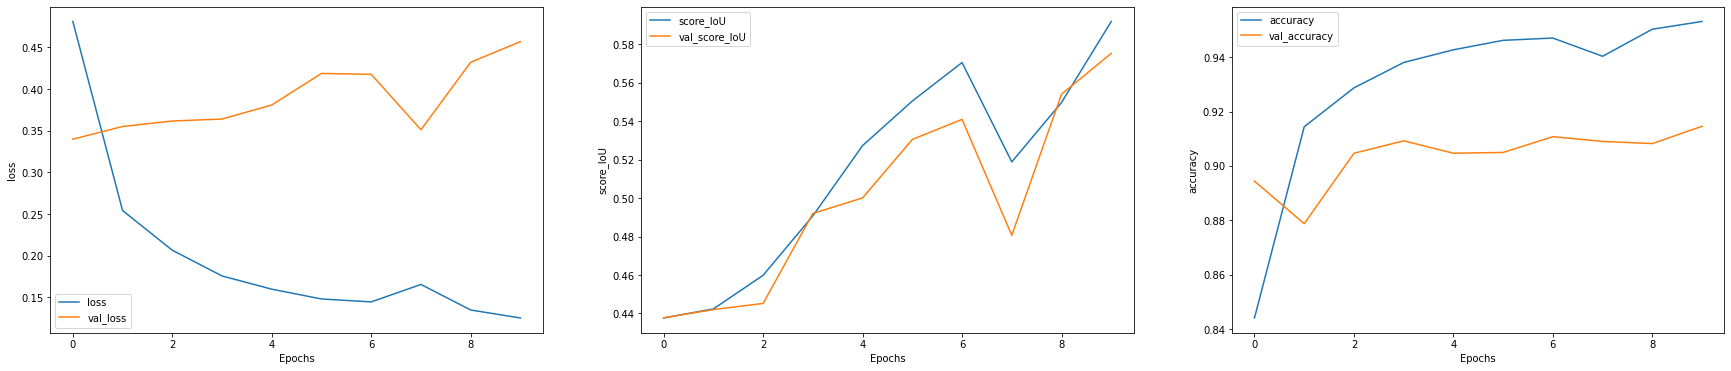

Training time : 11627.283855199814


In [ ]:
print(f'Training for {model_name}')

# Set checkpoints
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}.h5', 
                             save_best_only=True)]

# Train the model
start = time()

model.train(train_images = train_input_dir,
            train_annotations = train_target_dir,
            batch_size = batch_size,
            input_height=img_height,
            input_width=img_width,
            n_classes=n_classes,
            validate=True,
            val_images=val_input_dir,
            val_annotations=val_target_dir, 
            epochs=epochs,
            loss=None,
            callbacks=callbacks,
            display_history=True)

training_time = time() - start
print(f'Training time : {training_time}')

# Save the model
model.save(model_path+f'/{model_name}.h5')

### **<font color=blue>Evaluer le modèle</font>**

In [ ]:
# Evaluate the model
start_eval = time()
model_result = model.evaluate_segmentation(inp_images_dir=test_input_dir,
                                           annotations_dir=test_target_dir)
start_eval = time()
print(f'Evaluation time : {eval_time}')

500it [04:51,  1.72it/s]

Evaluation time : 291.4993348121643


In [ ]:
# Reload result dataframe if necessary
# df_result = pd.read_csv(project_path +'/p8_bench_results.csv')

# Display all results associated to the current model
df_result = model_result_to_dataframe(model_name, epochs, training_time,
                                      eval_time, df_result, model_result,
                                      do_augment=False)

# Save to CSV
df_result.to_csv(project_path +'/p8_bench_models.csv', index=False)

# Display result
df_result

model epoch  training_time  ...  sky_IoU  human_IoU  vehicule_IoU
0  fcn_8_mobilenet    10   11627.283855  ...  0.85441   0.464048       0.79923

[1 rows x 14 columns]

### **<font color=blue>Visualiser les prédictions</font>**

[168 415  40 439  43]


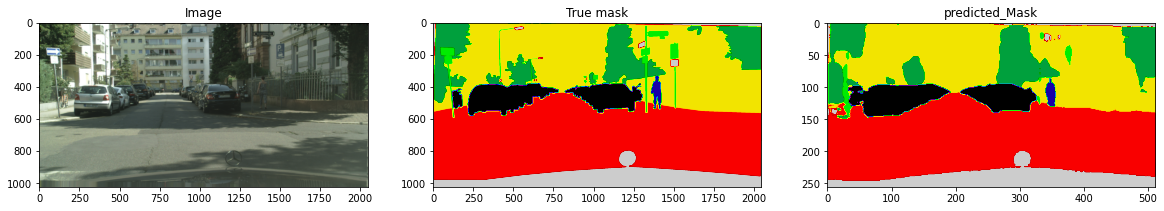

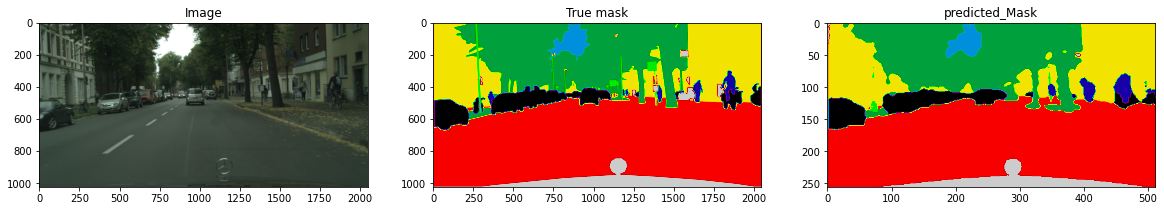

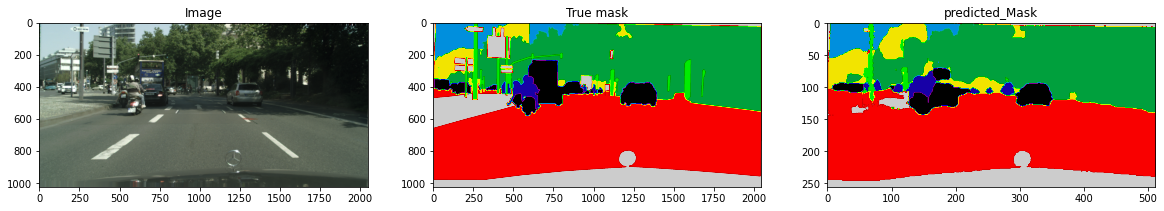

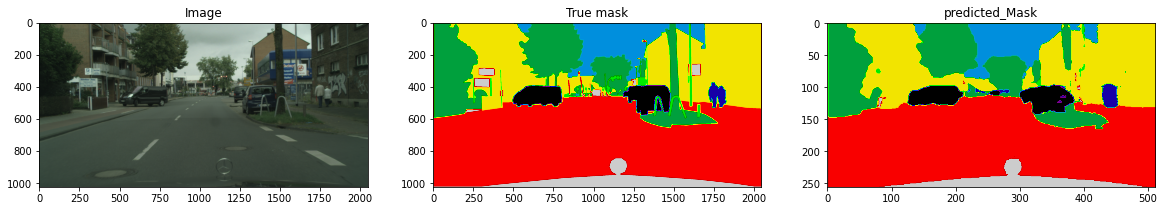

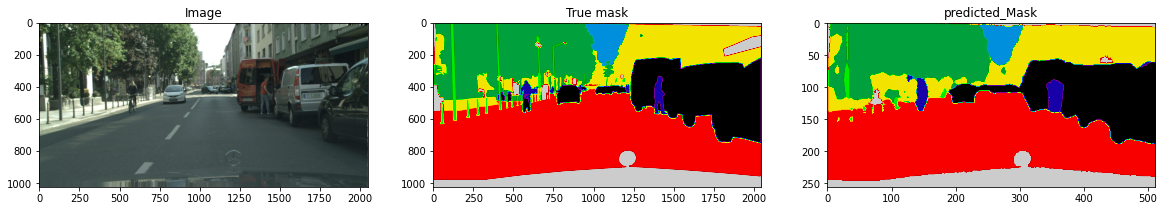

In [ ]:
# Plot image, mask and prediction
plot_image_mask_prediction(test_input_path, test_target_path, 
                           img_height, img_width, random=True, n=5)

## **<font color=green>Segnet - Mobilenet</font>**

### **<font color=blue>Appeler le modèle</font>**

In [ ]:
# Clear previous session
K.clear_session()

# Name next model to benchmark
model_name= 'mobilenet_segnet'

# Call the model
model = mobilenet_segnet(n_classes=n_classes,
                         input_height=img_height,
                         input_width=img_width)

17235968/17225924 [==============================] - 1s 0us/step


In [ ]:
# Check model summary
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 512, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 258, 514, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 128, 256, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 128, 256, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (Activation)     (None, 128, 256, 32)      0         
                                                                 
 conv_pad_1 (ZeroPadding2D)  (None, 130, 258, 32)      0         
                                                           

### **<font color=blue>Entraîner le modèle</font>**

Training for mobilenet_segnet
Verifying training dataset


100%|██████████| 2380/2380 [30:32<00:00,  1.30it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 595/595 [06:51<00:00,  1.45it/s]


Dataset verified! 
Epoch 1/10
512/512 [==============================] - 822s 2s/step - loss: 0.3318 - score_IoU: 0.4375 - accuracy: 0.8918 - val_loss: 0.3067 - val_score_IoU: 0.4375 - val_accuracy: 0.8991
Epoch 2/10
512/512 [==============================] - 784s 2s/step - loss: 0.2144 - score_IoU: 0.4379 - accuracy: 0.9249 - val_loss: 0.3526 - val_score_IoU: 0.4379 - val_accuracy: 0.8935
Epoch 3/10
512/512 [==============================] - 776s 2s/step - loss: 0.1815 - score_IoU: 0.4406 - accuracy: 0.9355 - val_loss: 0.4171 - val_score_IoU: 0.4482 - val_accuracy: 0.9087
Epoch 4/10
512/512 [==============================] - 773s 2s/step - loss: 0.1636 - score_IoU: 0.4433 - accuracy: 0.9412 - val_loss: 0.3594 - val_score_IoU: 0.4494 - val_accuracy: 0.9037
Epoch 5/10
512/512 [==============================] - 773s 2s/step - loss: 0.1518 - score_IoU: 0.4459 - accuracy: 0.9449 - val_loss: 0.3690 - val_score_IoU: 0.4476 - val_accuracy: 0.9079
Epoch 6/10
512/512 [==========================

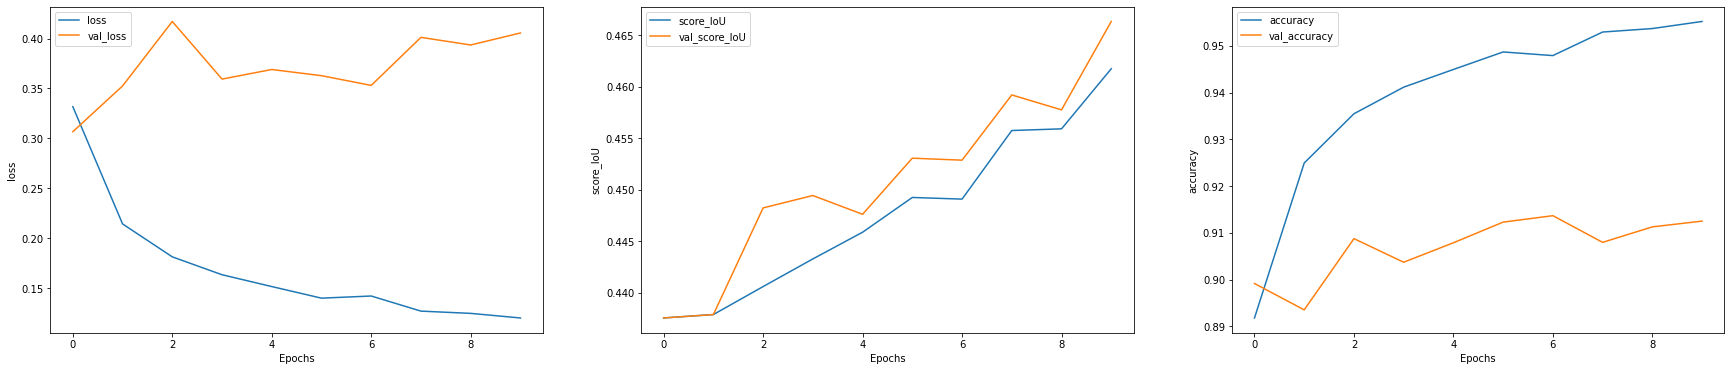

Training time : 10133.6909263134


In [ ]:
print(f'Training for {model_name}')

# Set checkpoints
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}.h5', 
                             save_best_only=True)]

# Train the model
start = time()

model.train(train_images = train_input_dir,
            train_annotations = train_target_dir,
            batch_size = batch_size,
            input_height=img_height,
            input_width=img_width,
            n_classes=n_classes,
            validate=True,
            val_images=val_input_dir,
            val_annotations=val_target_dir, 
            epochs=epochs,
            loss=None,
            callbacks=callbacks,
            display_history=True)

training_time = time() - start
print(f'Training time : {training_time}')

# Save the model
model.save(model_path+f'/{model_name}.h5')

### **<font color=blue>Evaluer le modèle</font>**

In [ ]:
# Evaluate the model
start_eval = time()
model_result = model.evaluate_segmentation(inp_images_dir=test_input_dir,
                                           annotations_dir=test_target_dir)
eval_time = time() - start_eval
print(f'Evaluation time : {eval_time}')

500it [06:31,  1.28it/s]

Evaluation time : 392.30723690986633


In [ ]:
# Reload result dataframe if necessary
# df_result = pd.read_csv(project_path +'/p8_bench_models.csv')

# Display all results associated to the current model
df_result = model_result_to_dataframe(model_name, epochs, training_time,
                                      eval_time, df_result, model_result,
                                      do_augment=False)

# Save to CSV
df_result.to_csv(project_path +'/p8_bench_models.csv', index=False)

# Display result
df_result

model  epoch  training_time  ...   sky_IoU  human_IoU  vehicule_IoU
0   fcn_8_mobilenet     10   11627.283855  ...  0.854410   0.464048      0.799230
1  mobilenet_segnet     10   10133.690926  ...  0.843537   0.513266      0.794738

[2 rows x 14 columns]

### **<font color=blue>Visualiser les prédictions</font>**

[  8 129 363 114 266]


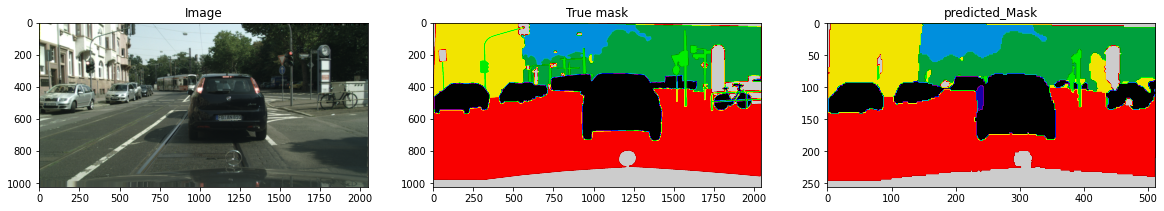

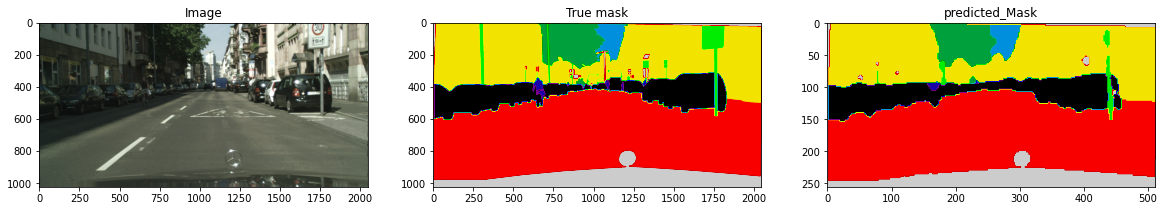

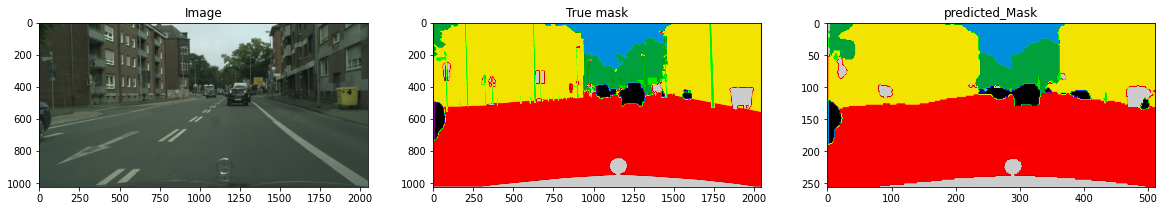

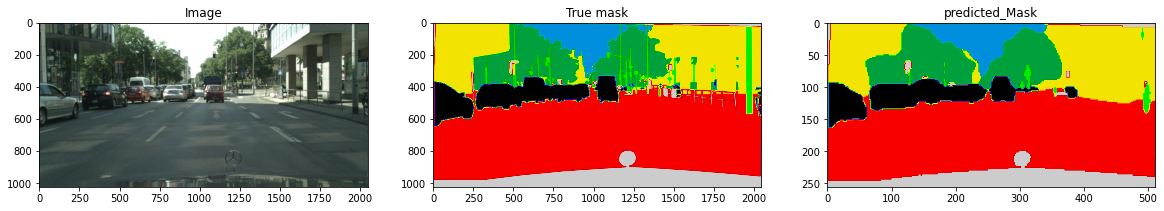

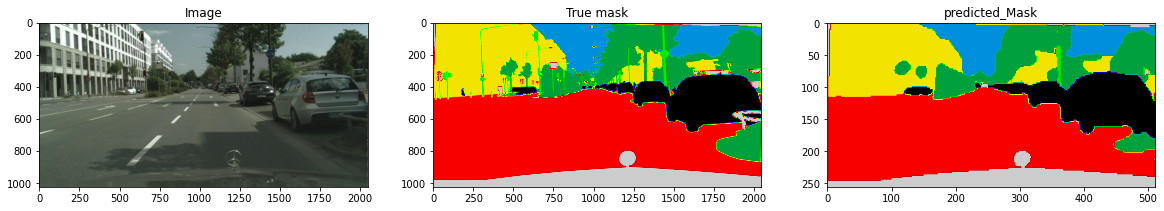

In [ ]:
# Plot image, mask and prediction
plot_image_mask_prediction(test_input_path, test_target_path, 
                           img_height, img_width, random=True, n=5)

## **<font color=green>Unet - Vgg16</font>**

### **<font color=blue>Appeler le modèle</font>**

In [ ]:
# Clear previous session
K.clear_session()

# Name next model to benchmark
model_name= 'vgg_unet'

# Call the model
model = vgg_unet(n_classes=n_classes,
                 input_height=img_height,
                 input_width=img_width)

58900480/58889256 [==============================] - 3s 0us/step


In [ ]:
# Check model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

### **<font color=blue>Entraîner le modèle</font>**

Training for vgg_unet
Verifying training dataset


100%|██████████| 2380/2380 [03:12<00:00, 12.38it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 595/595 [00:47<00:00, 12.58it/s]


Dataset verified! 
Epoch 1/10
512/512 [==============================] - 791s 2s/step - loss: 0.4850 - score_IoU: 0.4407 - accuracy: 0.8505 - val_loss: 0.3849 - val_score_IoU: 0.4375 - val_accuracy: 0.8810
Epoch 2/10
512/512 [==============================] - 787s 2s/step - loss: 0.2895 - score_IoU: 0.4377 - accuracy: 0.9068 - val_loss: 0.3450 - val_score_IoU: 0.4379 - val_accuracy: 0.8912
Epoch 3/10
512/512 [==============================] - 789s 2s/step - loss: 0.2442 - score_IoU: 0.4382 - accuracy: 0.9193 - val_loss: 0.3063 - val_score_IoU: 0.4383 - val_accuracy: 0.9044
Epoch 4/10
512/512 [==============================] - 787s 2s/step - loss: 0.2460 - score_IoU: 0.4381 - accuracy: 0.9185 - val_loss: 0.2950 - val_score_IoU: 0.4383 - val_accuracy: 0.9080
Epoch 5/10
512/512 [==============================] - 785s 2s/step - loss: 0.1979 - score_IoU: 0.4387 - accuracy: 0.9330 - val_loss: 0.3113 - val_score_IoU: 0.4387 - val_accuracy: 0.9030
Epoch 6/10
512/512 [==========================

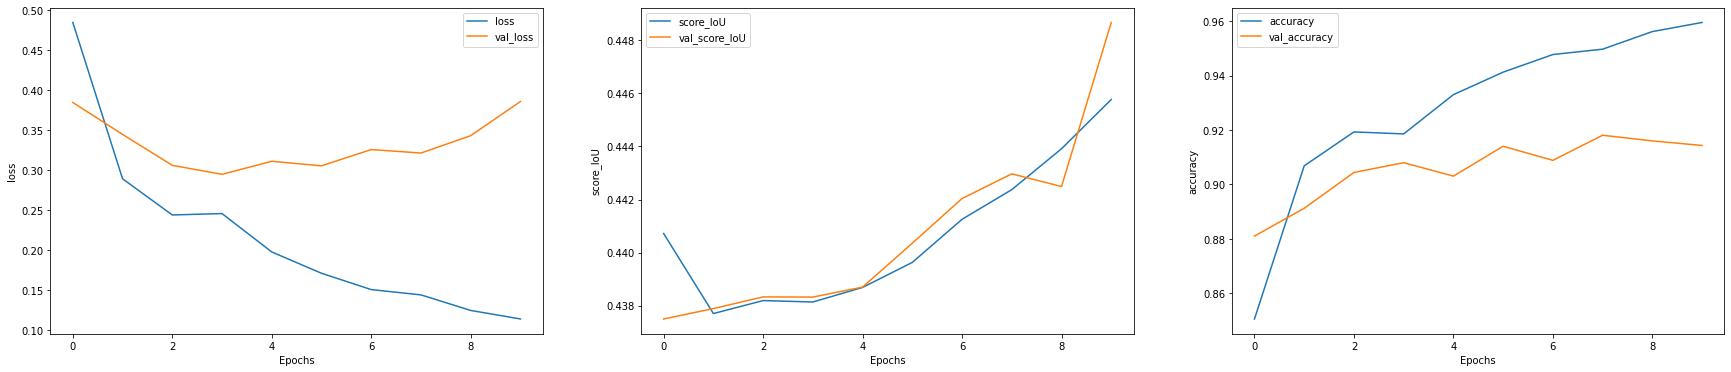

Training time : 8106.143540859222


In [ ]:
print(f'Training for {model_name}')

# Set checkpoints
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}.h5', 
                             save_best_only=True)]

# Train the model
start = time()

model.train(train_images = train_input_dir,
            train_annotations = train_target_dir,
            batch_size = batch_size,
            input_height=img_height,
            input_width=img_width,
            n_classes=n_classes,
            validate=True,
            val_images=val_input_dir,
            val_annotations=val_target_dir, 
            epochs=epochs,
            loss=None,
            callbacks=callbacks,
            display_history=True)

training_time = time() - start
print(f'Training time : {training_time}')

# Save the model
model.save(model_path+f'/{model_name}.h5')

### **<font color=blue>Evaluer le modèle</font>**

In [ ]:
# Evaluate the model
start_eval = time()
model_result = model.evaluate_segmentation(inp_images_dir=test_input_dir,
                                           annotations_dir=test_target_dir)
eval_time = time() - start_eval
print(f'Evaluation time : {eval_time}')

500it [01:24,  5.88it/s]

Evaluation time : 85.34302067756653


In [ ]:
# Reload result dataframe if necessary
# df_result = pd.read_csv(project_path +'/p8_bench_models.csv')

# Display all results associated to the current model
df_result = model_result_to_dataframe(model_name, epochs, training_time, 
                                       eval_time, df_result, model_result, 
                                       do_augment=False)
# Save to CSV
df_result.to_csv(project_path +'/p8_bench_models.csv', index=False)

# Display result
df_result

model  epoch  training_time  ...   sky_IoU  human_IoU  vehicule_IoU
0   fcn_8_mobilenet     10   11627.283855  ...  0.854410   0.464048      0.799230
1  mobilenet_segnet     10   10133.690926  ...  0.843537   0.513266      0.794738
2          vgg_unet     10    8106.143541  ...  0.889043   0.576151      0.813161

[3 rows x 14 columns]

### **<font color=blue>Visualiser les prédictions</font>**

[226 242  79 218 111]


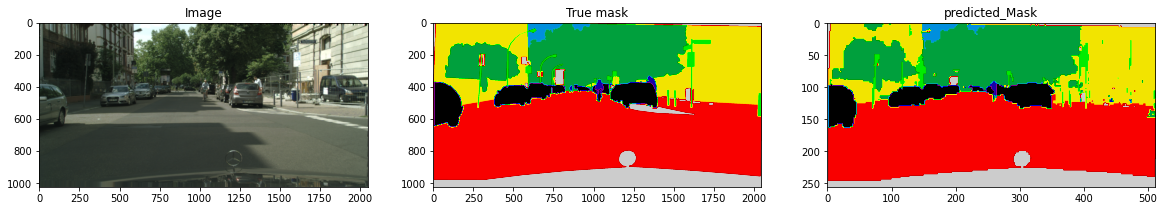

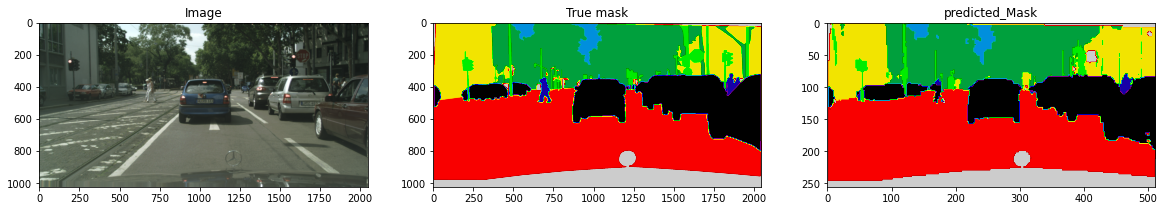

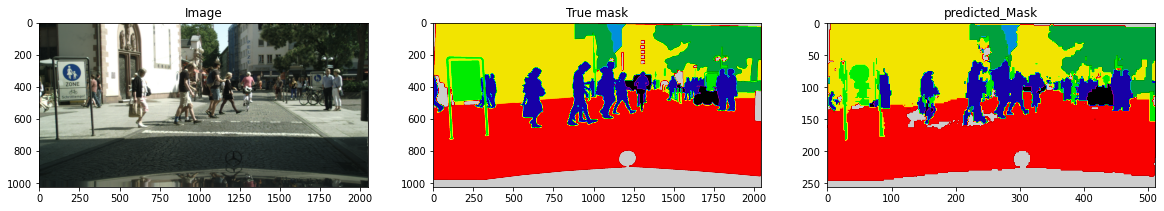

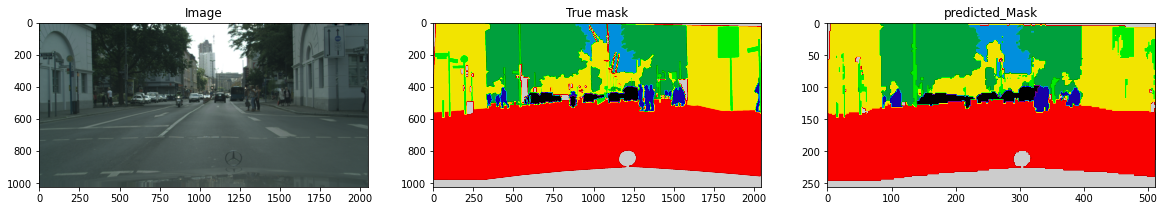

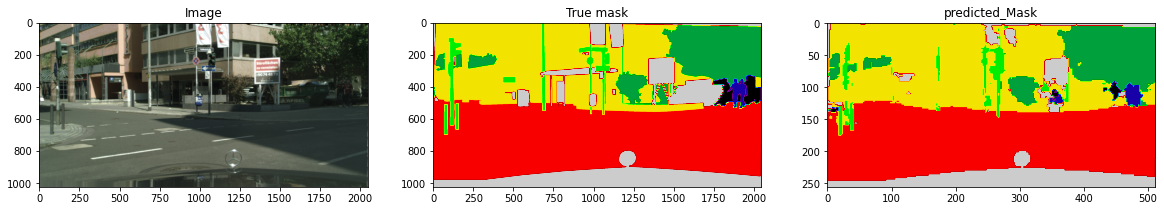

In [ ]:
# Plot image, mask and prediction
plot_image_mask_prediction(test_input_path, test_target_path, 
                           img_height, img_width, random=True, n=5)

## **<font color=green>Synthèse et choix du modèle</font>**

### **<font color=blue>Tableau de synthèse</font>**

In [ ]:
# Display result
df_result

model  epoch  training_time  ...   sky_IoU  human_IoU  vehicule_IoU
0   fcn_8_mobilenet     10   11627.283855  ...  0.854410   0.464048      0.799230
1  mobilenet_segnet     10   10133.690926  ...  0.843537   0.513266      0.794738
2          vgg_unet     10    8106.143541  ...  0.889043   0.576151      0.813161

[3 rows x 14 columns]

<font color=red>**Sans conteste, Vgg-Unet est le meilleur modèle, autant en termes de performance  globale (74,1 % de IoU), que de performance sur les classes sous-représentées (human, object); il est également le modèle qui a pris le moins de temps à entraîner.**</font>

### **<font color=blue>Critères de sélection</font>**

Les modèles occupent l'espace mémoire suivant :
- **FCN8-Mobilenet** = 2,52 Go ;
- **MobileNet-Segnet** = 63,8 Mo ;
- **VGG-Unet** = 141,2 Mo.

Nous pensons que, même s'il est moins performant que VGG-Unet, <font color=green>**MobileNet-Segnet**</font> est le modèle qui occupent le moins d'espace mémoire, et donc qui serait facile à embarquer dans un système de voiture autonome et qui souffrirait le moins de latence. 

Nous sélectionnons ce modèle pour la suite de notre projet.